<a href="https://colab.research.google.com/github/michalis0/Business-Intelligence-and-Analytics/blob/master/week9%20-%20Regression2/Walkthrough/%20Walkthrough_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Walkthrough : Regression 2

This week we continue working on regression. Diving into more specific methods, we will show you how to choose the number of parameters, cross validation and 1-hot/label encoding.

#Regression with categorical variables

In [19]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import statistics

## Load the dataset

The Dataset we will be working on was extracted and modified from [Kaggle](https://www.kaggle.com/mohansacharya/graduate-admissions). It gives us various information concerning students and their chances of admission.


In [20]:
#Load the dataset
url = 'https://raw.githubusercontent.com/michalis0/Business-Intelligence-and-Analytics/master/data/Admissions_prediction.csv'
GAD = pd.read_csv(url, sep = ";", index_col= 'Serial No.').drop_duplicates() #Graduate Admissions Data

# Display a sample of the data
display(GAD.head())
#Print the data types
print(GAD.dtypes)
print("Data matrix shape: ", GAD.shape)
# display the columns names


,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,GOOD,4.5,4.5,9.65,YES,0.92
2,324,107,GOOD,4.0,4.5,8.87,YES,0.76
3,316,104,AVERAGE,3.0,3.5,8.00,YES,0.72
4,322,110,AVERAGE,3.5,2.5,8.67,YES,0.80
5,314,103,FAIR,2.0,3.0,8.21,NO,0.65


GRE Score              int64
TOEFL Score            int64
University Rating     object
SOP                  float64
LOR                  float64
CGPA                 float64
Research              object
Chance of Admit      float64
dtype: object
Data matrix shape:  (400, 8)


An overview of the columns:

 
 * `GRE Score`: GRE is a standardized admission test (out of 340)
 * `TOEFL Score`: English knowledge (out of 120)
 * `SOP`: Standard of Purpose (out of 5)
 * `LOR`: Letter of Recomendation (out of 5)
 * `CGPA`: College GPA (out of 10)
 * `RESEARCH`: Whether the applicant did research or not
 
 We will try to predict the chance of admit with the other variables.

## Handling categorical variables for regression

First, let's focus on the `Research` column. The applicant was either active in research, or he was not. There are therefore only 2 possible values, hence we will assign 1 for YES and 0 for NO.



In [21]:
GAD['Research'] = GAD['Research'].replace(['NO', 'YES'], [0,1])

In [22]:
display(GAD.head())

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,GOOD,4.5,4.5,9.65,1,0.92
2,324,107,GOOD,4.0,4.5,8.87,1,0.76
3,316,104,AVERAGE,3.0,3.5,8.00,1,0.72
4,322,110,AVERAGE,3.5,2.5,8.67,1,0.80
5,314,103,FAIR,2.0,3.0,8.21,0,0.65


Here let's get a quick overview of the existing correlations between our variables using a heatmap.

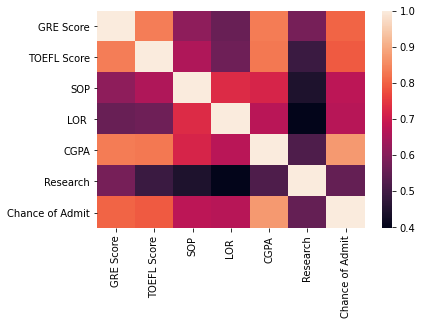

In [23]:
d = (sns.heatmap(GAD.corr()))

In [24]:
#We want to predict the chance of admission
y = GAD[['Chance of Admit']]

#With the help of the other columns
X = GAD.drop('Chance of Admit', axis = 1)

Now we need to handle the `University Ranking`. 
We will do both, one-hot and label encoding.
For label encoding, we can use Sklearn's LabelEncoder() function. 


In [25]:
#Label encoder
X_label = X.apply(LabelEncoder().fit_transform)

In [26]:
display(X_label.head())

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
Serial No.,,,,,,,
1,45,26,3,7,7,156,1
2,32,15,3,6,7,101,1
3,24,12,0,4,5,32,1
4,30,18,0,5,3,84,1
5,22,11,2,2,4,49,0


For one hot encoding we use pandas get dummy function.

In [27]:
#1-hot encoding

#We create a DF with Dummy variables
dummies = pd.get_dummies(GAD["University Rating"])
X_hot = pd.concat([GAD, dummies], axis = 1)

#We drop the Rating column 
del X_hot["University Rating"]
del X_hot["Chance of Admit"]

#Have a look at what dummies actually looks like
dummies

,AVERAGE,EXCELLENT,FAIR,GOOD,POOR
Serial No.,,,,,
1,0,0,0,1,0
2,0,0,0,1,0
3,1,0,0,0,0
4,1,0,0,0,0
5,0,0,1,0,0
...,...,...,...,...,...
396,1,0,0,0,0
397,1,0,0,0,0
398,0,0,0,1,0


In [28]:
display(X_hot.head())

,GRE Score,TOEFL Score,SOP,LOR,CGPA,Research,AVERAGE,EXCELLENT,FAIR,GOOD,POOR
Serial No.,,,,,,,,,,,
1,337,118,4.5,4.5,9.65,1,0,0,0,1,0
2,324,107,4.0,4.5,8.87,1,0,0,0,1,0
3,316,104,3.0,3.5,8.00,1,1,0,0,0,0
4,322,110,3.5,2.5,8.67,1,1,0,0,0,0
5,314,103,2.0,3.0,8.21,0,0,0,1,0,0


We will now build two models, one for 1-hot encoding and one for label encoding.
Let's start with label encoding:

In [29]:
#Split Dataset
X_train_lab, X_test_lab, y_train_lab, y_test_lab = train_test_split(X_label, y, test_size=0.2, random_state=0, shuffle=True)

#Fit the model
model_lab = LinearRegression()
model_lab.fit(X_train_lab, y_train_lab)

#Calculate R2
lab_r2 = round(model_lab.score(X_test_lab, y_test_lab), 4)
print("R^2 Score using label encoding: ", lab_r2 )

#Calculate Scores on Test-Set
label_predictions = model_lab.predict(X_test_lab)
lab_mae = mean_absolute_error(y_test_lab, label_predictions)
lab_mse = mean_squared_error(y_test_lab, label_predictions)
lab_r2_test = r2_score(y_test_lab, label_predictions)

print("MAE LAB %.2f" % lab_mae)
print("MSE LAB %.2f" % lab_mse)
print("R^2 LAB %.6f" % lab_r2)


R^2 Score using label encoding:  0.7353
MAE LAB 0.05
MSE LAB 0.00
R^2 LAB 0.735300


And continue with 1-hot:

In [30]:
#Split Dataset
X_train_hot, X_test_hot, y_train_hot, y_test_hot = train_test_split(X_hot, y, test_size=0.2, random_state=0, shuffle=True)

#Fit the model
model_hot = LinearRegression()
model_hot.fit(X_train_hot, y_train_hot)

#Calculate R2
hot_r2 = round(model_hot.score(X_test_hot, y_test_hot), 4)
print("R^2 Train Score using 1-hot encoding : ", hot_r2 )

#Calculate Scores on Test-Set
hot_predictions = model_hot.predict(X_test_hot)
hot_mae = mean_absolute_error(y_test_hot, hot_predictions)
hot_mse = mean_squared_error(y_test_hot, hot_predictions)
hot_r2_test = r2_score(y_test_hot, hot_predictions)


print("MAE HOT %.2f" % hot_mae)
print("MSE HOT %.2f" % hot_mse)
print("R^2 HOT %.6f" % hot_r2)


R^2 Train Score using 1-hot encoding :  0.7403
MAE HOT 0.05
MSE HOT 0.00
R^2 HOT 0.740300


In [31]:
print("The 1-hot encoding method yields an R^2 {}% higher than using label encoding for the train set.".format(round((hot_r2/lab_r2 -1)*100, 3)))

The 1-hot encoding method yields an R^2 0.68% higher than using label encoding for the train set.


In [32]:
print("The 1-hot encoding method yields an R^2 {}% higher than using label encoding for the test set.".format(round((hot_r2_test/lab_r2_test -1)*100, 3)))

The 1-hot encoding method yields an R^2 0.681% higher than using label encoding for the test set.


Have a look at how the coefficients change for each method:

In [33]:
print("Intercept: ", model_hot.intercept_[0]) 
print("Intercept: ", model_lab.intercept_[0])

Intercept:  -1.284738524004081
Intercept:  0.4349455444112228


In [34]:
weights_hot = model_hot.coef_.flatten()
weights_lab = model_lab.coef_.flatten()
print("Features coefficients for HOT (weigths): ", model_hot.coef_)
print("Features coefficients for LAB (weigths): ", model_lab.coef_)

Features coefficients for HOT (weigths):  [[ 0.0020506   0.00202487 -0.00418539  0.02129711  0.12447107  0.02416713
  -0.0036891   0.01520818 -0.01014306  0.00121785 -0.00259387]]
Features coefficients for LAB (weigths):  [[ 0.0021034   0.00230572 -0.00114255 -0.00210265  0.01185525  0.00176492
   0.02338176]]


# Polynomial linear regression

We will now have a look at another model. We are going to use `Advertisement` data we used last week. The task is to figure out how different means of advertisement influence the amount of sales of a product.

In [35]:
ad_df = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week4/data/Advertising.csv', index_col = "id")
# view the first 5 rows 
ad_df.head()

,TV,Radio,Newspaper,Sales
id,,,,
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [36]:
y = ad_df["Sales"]
X = ad_df.drop("Sales", axis = 1)

In [37]:
#First let's go for a linear multivariate regression
#You should know the drill by now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

# 3. Performance metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Test scores: ")
print("MAE %.2f" % mae)
print("MSE %.2f" % mse)
print("R^2 %.2f" % r2)

print("Train metrics")
print("params: ", model.coef_)
print("constant: ", model.intercept_)
print("R^2 score: ", model.score(X, y))

Test scores: 
MAE 1.36
MSE 4.40
R^2 0.86
Train metrics
params:  [ 0.04458402  0.19649703 -0.00278146]
constant:  2.99489303049533
R^2 score:  0.8964076641629948


Using polynomial regression enables you to predict the best fit line that follows the pattern(curve) of the data. It tends to increase the performance of the model. The function PolynomialFeatures generates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2]. Let's try it on our model.

In [38]:
# Polynomial regression
poly = PolynomialFeatures(2)
X = np.array(ad_df[["TV", "Radio"]])
y = np.array(ad_df["Sales"])
X_poly = poly.fit_transform(X) #Normalizing

In [39]:
LR = LinearRegression(fit_intercept=False) # we don't need fit intercept sice polynomial features function add a column of ones to the data 
LR.fit(X_poly, y)
print("params: ", LR.coef_)
print("R^2 score: ", LR.score(X_poly, y))

params:  [ 5.19444187e+00  5.09930683e-02  2.65400299e-02 -1.09816273e-04
  1.07462080e-03  1.86076136e-04]
R^2 score:  0.986039101078374


## Overfitting
Beware, adding too many features may cause overfitting.
Remember that overfitting is is the tendency of data mining procedures to tailor models to the training data, at the expense of generalization to previously unseen data points. We want to avoid this case.

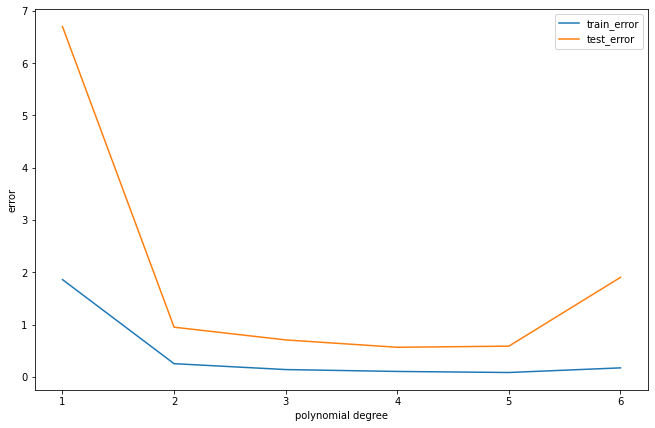

In [40]:
train_err = []
test_err = []
for f in range(1,7):
    poly = PolynomialFeatures(f)
    X_poly = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=10)
    LR = LinearRegression(fit_intercept=True)
    LR.fit(X_train, y_train)
    train_err.append(mean_squared_error(y_train, LR.predict(X_train)))
    test_err.append(mean_squared_error(y_test, LR.predict(X_test)))


fig=plt.figure(figsize=(11,7))
plt.plot(range(1,7), train_err, label="train_error")
plt.plot(range(1,7), test_err, label="test_error")
plt.legend(fontsize=10)
plt.xlabel("polynomial degree")
dummy = plt.ylabel("error")


In [41]:
from sklearn.model_selection import KFold


y = ad_df["Sales"]
X = ad_df.drop("Sales", axis = 1)

kf = KFold(n_splits = 10, random_state = None)
model = LinearRegression()

mae_cumm = []
mse_cumm = []
r2_cumm = []

for train_index, test_index in kf.split(X):
  
  X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  model.fit(X_train, y_train)
  predictions = model.predict(X_test)


  mae = mean_absolute_error(y_test, predictions)
  mse = mean_squared_error(y_test, predictions)
  r2 = r2_score(y_test, predictions)

  mae_cumm.append(mae)
  mse_cumm.append(mse)
  r2_cumm.append(r2)

  
mean_mae = sum(mae_cumm)/len(mae_cumm)
mean_mse = sum(mse_cumm)/len(mse_cumm)
mean_r2 = sum(r2_cumm)/len(r2_cumm)

print("The mean absolute error of all our folds was: ",round(mean_mae, 3))
print("The mean squared error of all our folds was: ", round(mean_mse, 3))
print("The mean accuracy of all our folds was: ", round(mean_r2, 3))


The mean absolute error of all our folds was:  1.302
The mean squared error of all our folds was:  3.06
The mean accuracy of all our folds was:  0.885


And for higher order polynomial regression:

[2.770302360080497, 0.3625454931923564, 0.2108067440804634, 0.1388456357986511, 0.07067892817106887, 0.06930413027164153]
[3.059967618118513, 0.4298542565083259, 0.31902203062418744, 0.26580305296914536, 2.433299571778639, 87.3738850230753]


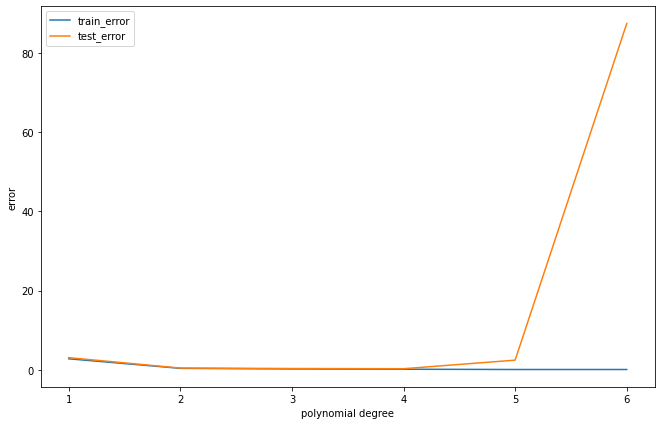

In [42]:
train_err = []
test_err = []

y = ad_df["Sales"]
X = ad_df.drop("Sales", axis = 1)

kf = KFold(n_splits = 10, random_state = None)
model = LinearRegression(fit_intercept = False)

for f in range(1,7):
  train = []
  test = []
  for train_index, test_index in kf.split(X):
    poly = PolynomialFeatures(f)
    X_poly = poly.fit_transform(X)
    X_train, X_test = X_poly[train_index,:], X_poly[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    train.append(mean_squared_error(y_train, model.predict(X_train)))
    test.append(mean_squared_error(y_test, model.predict(X_test)))

  train_err.append(statistics.mean(train))
  test_err.append(statistics.mean(test))

fig=plt.figure(figsize=(11,7))
plt.plot(range(1,7), train_err, label="train_error")
plt.plot(range(1,7), test_err, label="test_error")
plt.legend(fontsize=10)
plt.xlabel("polynomial degree")
plt.ylabel("error")
print(train_err)
print(test_err)